In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mkucz95/kickstarter_data/master/ks-projects-201801.csv')

# IA. Exploratory Data Analysis

In [81]:
# report = ProfileReport(df)
# report

# IB. Wrangle Data/Feature Engineering

In [3]:
df = df[['main_category','launched','deadline','currency','goal','pledged','backers','state']]
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
df = df.rename(columns={'main_category': 'category'})
df['campaign_length'] = df['deadline'] - df['launched']
df['campaign_length'] = df['campaign_length'].dt.days
df['percentage_pledged'] = (df['pledged'] / df['goal']) * 100
df = df[['category','campaign_length','currency','percentage_pledged','backers','state']]
df.drop(df[(df.state == 'live')].index,inplace=True)
df.drop(df[(df.state == 'undefined')].index,inplace=True)
df.loc[df.state == "canceled", 'state'] = "failed"
df.loc[df.state == "suspended", 'state'] = "failed"

In [4]:
df['state'].unique()

array(['failed', 'successful'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372300 entries, 0 to 378660
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   category            372300 non-null  object 
 1   campaign_length     372300 non-null  int64  
 2   currency            372300 non-null  object 
 3   percentage_pledged  372300 non-null  float64
 4   backers             372300 non-null  int64  
 5   state               372300 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 19.9+ MB


In [6]:
currencies=pd.get_dummies(df.currency,prefix='currency')

In [8]:
df=pd.concat([df,currencies],axis=1)

In [9]:
df.drop('currency', axis=1, inplace=True)

In [10]:
categories=pd.get_dummies(df.category,prefix='category')
df=pd.concat([df,categories],axis=1)

In [11]:
df.drop('category', axis=1, inplace=True)

In [12]:
states=pd.get_dummies(df.state,drop_first=True)
df=pd.concat([df,states],axis=1)
df.drop('state',axis=1,inplace=True)

In [13]:
df

,campaign_length,percentage_pledged,backers,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,...,category_Film & Video,category_Food,category_Games,category_Journalism,category_Music,category_Photography,category_Publishing,category_Technology,category_Theater,successful
0,58,0.000000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,59,8.070000,15,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,44,0.488889,3,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,29,0.020000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,55,6.579487,14,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,29,0.050000,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
378657,26,10.333333,5,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
378658,45,0.133333,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
378659,30,1.333333,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# II. Split Data

In [14]:
target = 'successful'
y = df[target]
X = df.drop(columns=target)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=.6, test_size=.4, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,train_size=.5,test_size=.5, random_state=1)

# III. Establish Baseline

In [16]:
y_train.value_counts(normalize=True).max()

0.6408317664965529

# IV. Build Model

In [17]:
model_rf = make_pipeline(
   RandomForestClassifier(max_samples=23,random_state=42,n_jobs=-1)
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_samples=23, n_jobs=-1,
                                        random_state=42))])

# V. Tune Model

 * tuning max_samples

In [18]:
%matplotlib inline

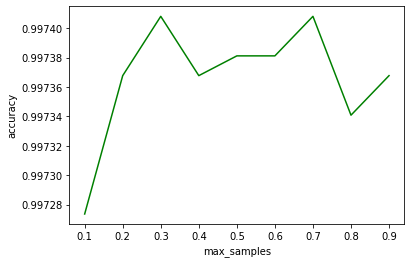

In [19]:
train_acc = []
val_acc = []
samples = np.arange(.1, 1, 0.1)

for sample in samples:

  forest_model = make_pipeline(
      RandomForestClassifier(max_samples=sample, n_estimators=29, random_state=42, n_jobs =-1)
  )

  forest_model.fit(X_train, y_train)
  val_acc.append(forest_model.score(X_val, y_val))

plt.plot(samples, val_acc, color='green')
plt.xlabel('max_samples')
plt.ylabel('accuracy')

plt.show()

In [20]:
max_accuracy = max(val_acc)
max_samples = np.where(val_acc == max_accuracy)
xmax = samples[max_samples]

xmax

array([0.3, 0.7])

 * tuning max_samples

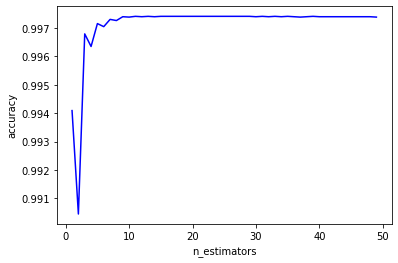

In [22]:
train_acc = []
val_acc = []
estimators = np.arange(1, 50, 1)

for estimator in estimators:

  forest_model = make_pipeline(
      RandomForestClassifier(max_samples=.3, n_estimators=estimator, random_state=42, n_jobs =-1)
  )

  forest_model.fit(X_train, y_train)
  val_acc.append(forest_model.score(X_val, y_val))

plt.plot(estimators, val_acc, color='blue')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.show()

In [23]:
ymax = max(val_acc)
xpos = np.where(val_acc == ymax)
xmax = estimators[xpos]

xmax

array([11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       31, 33, 35, 39])

# VI. Check Metrics

In [24]:
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_val,y_val))
print('Testing Accuracy', model_rf.score(X_test, y_test))

Training Accuracy 0.9889739457426806
Validation Accuracy 0.9893365565404244
Testing Accuracy 0.9891888262154177


# VII. Communicate Resultes